In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done

# set os cuda device



In [2]:
data_dir = "./data/VisNav_VR_Expt"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/117S-7NmbgrqjmjZ4QTNgoa-mx8R_yUso?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")



In [3]:
# load config files
import yaml

base_path = "./configs/visnav"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)




In [4]:
import mat73

data_path = "data/VisNav_VR_Expt/experiment_data.mat"
data = mat73.loadmat(data_path)['neuroformer']

# sel_2 -> VR + speed 
sel_2 = np.array(pd.read_csv("./data/VisNav_VR_Expt/yiyi/sel2.csv")).flatten()

print(data.keys())


dict_keys(['eyerad', 'phi', 'speed', 'spiketimes', 't', 'th', 'vid_sm'])


In [5]:
from SpikeVidUtils import trial_df, get_df_visnav

stimulus = data['vid_sm']
response = data['spiketimes']['spks']

print(data.keys())

df = get_df_visnav(response)
df = df[df['ID'].isin(sel_2)]
assert len(df['ID'].unique()) == len(sel_2)

behavior_vars = ['t', 'speed']        # ['t', 'eyerad', 'phi', 'speed', 'th']
behavior = pd.DataFrame({k: data[k] for k in behavior_vars})

# rename t to time
behavior = behavior.rename(columns={'t': 'Time'})


dict_keys(['eyerad', 'phi', 'speed', 'spiketimes', 't', 'th', 'vid_sm'])


In [6]:
frame_window = 0.2
window = 0.05
window_prev = 0.2
window_behavior = window
dt = 0.01
dt_frames = 0.05
dt_vars = 0.05
intervals = None

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)
behavior['Interval'] = make_intervals(behavior, window)
behavior['Interval_2'] = make_intervals(behavior, window_prev)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']



In [7]:
# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
var_group = 'Interval_2'
n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nlargest(int(0.05 * n_unique))



Interval_2  Trial
206.4       0        83
1280.2      0        79
457.0       0        78
1392.6      0        76
1037.2      0        73
                     ..
1492.4      0        27
1343.2      0        27
1550.4      0        27
919.0       0        27
580.6       0        27
Length: 405, dtype: int64

In [8]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus

frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
samples_per_behavior = int((window + window_prev) // dt_vars)
behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



In [9]:
# r_split = 0.8
# duration = df['Interval'].max()
# train_time = duration * r_split
# train_data = df[df['Interval'] <= train_time]
# test_data = df[df['Interval'] > train_time]

chunk_size = 20

# break intervals into chunks
intervals = df['Interval'].unique()
chunks = [intervals[i:i + chunk_size] for i in range(0, len(intervals), chunk_size)]

# randomly sample chunks for train and test sets
import random
r_split = 0.8
n_chunks = len(chunks)
n_train = int(n_chunks * r_split)
idx_sample = random.sample(range(n_chunks), n_train)
idx_rest = [i for i in range(n_chunks) if i not in idx_sample]
train_chunks = np.concatenate([chunks[i] for i in idx_sample]).flatten()
test_chunks = np.concatenate([chunks[i] for i in idx_rest]).flatten()
# test_chunks = np.concatenate([c for c in chunks if c.any() not in train_chunks]).flatten()



In [10]:
from SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=train_chunks, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
test_dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=test_chunks, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



Length: 95590 Neurons: 263
id block size: 100
frames: 46, id: 100
Using smooth intervals
Length: 95590 Neurons: 263
id block size: 100
frames: 46, id: 100
Using smooth intervals
train: 22640, test: 5654


In [11]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)



In [12]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)



In [13]:
for key in x.keys():
    print(key, x[key].shape)



id_prev torch.Size([2, 300])
dt_prev torch.Size([2, 300])
pad_prev torch.Size([2])
id torch.Size([2, 100])
dt torch.Size([2, 100])
pad torch.Size([2])
interval torch.Size([2])
trial torch.Size([2])
behavior torch.Size([2, 3, 4, 1])
behavior_dt torch.Size([2, 4])
frames torch.Size([2, 1, 4, 30, 100])
cid torch.Size([2, 2])
pid torch.Size([2, 2])
f_idx torch.Size([2, 2])


In [14]:
from model_neuroformer import GPT, GPTConfig

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 100
batch_size = round((32)) * 7
shuffle = True

title =  f'window:{window}_prev:{window_prev}_smooth'

model_path = f"""./models/tensorboard/visnav/speed-only/sel_2/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

model = GPT(model_conf)

11776
256 23


In [15]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=9e-5, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
# trainer.train()

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
from utils import predict_raster_recursive_time_auto

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.2
temp_t = 1.2

# with io.capture_output() a
#s captured:
# df_trial = df[(df['interval'] > test_int_min) & (df['interval'] < test_int_min + 100)]
trial_chunks = test_chunks[:10000]
trial_dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=trial_chunks, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                    sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                    frame_end=0, get_dt=True, gpu=False, pred_dt=True)
# results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
# print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
if df_pred is None:
    df_pred = df_trial_pred
    df_true = df_trial_true


dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv')) 



Length: 95590 Neurons: 263
id block size: 100
frames: 46, id: 100
Using smooth intervals


len pred: 396, len true: 624:   3%|▎         | 181/5654 [02:19<1:10:08,  1.30it/s]


KeyboardInterrupt: 

In [28]:
from analysis import get_rates_trial, calc_corr_psth, get_rates_trial

df_1 = df[df['Interval'].isin(trial_chunks)].reset_index(drop=True)
df_pred_full = df_pred

window_pred = 0.5
window_pred = window if window_pred is None else window_pred
# intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
# labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
labels = trial_chunks
intervals = trial_chunks
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

rates_pred = get_rates_trial(df_pred_full, intervals)
rates_1 = get_rates_trial(df_1, intervals)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)

/home/antonis/miniconda3/envs/neuroformer/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


len_pred: 1869, len_true: 2808
pred: defaultdict(<class 'list'>, {'precision': 0.005884995507637016, 'recall': 0.006626235399820306, 'F1': 0.0060785949599965776})
223


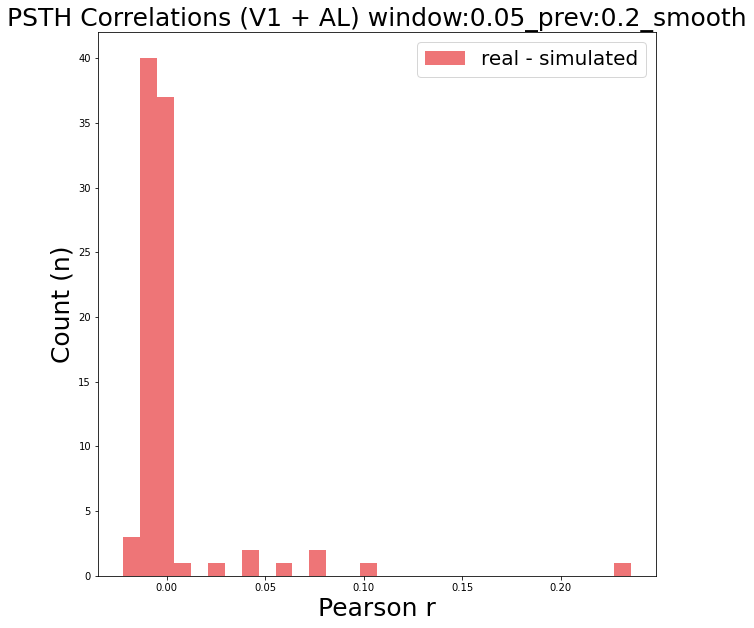

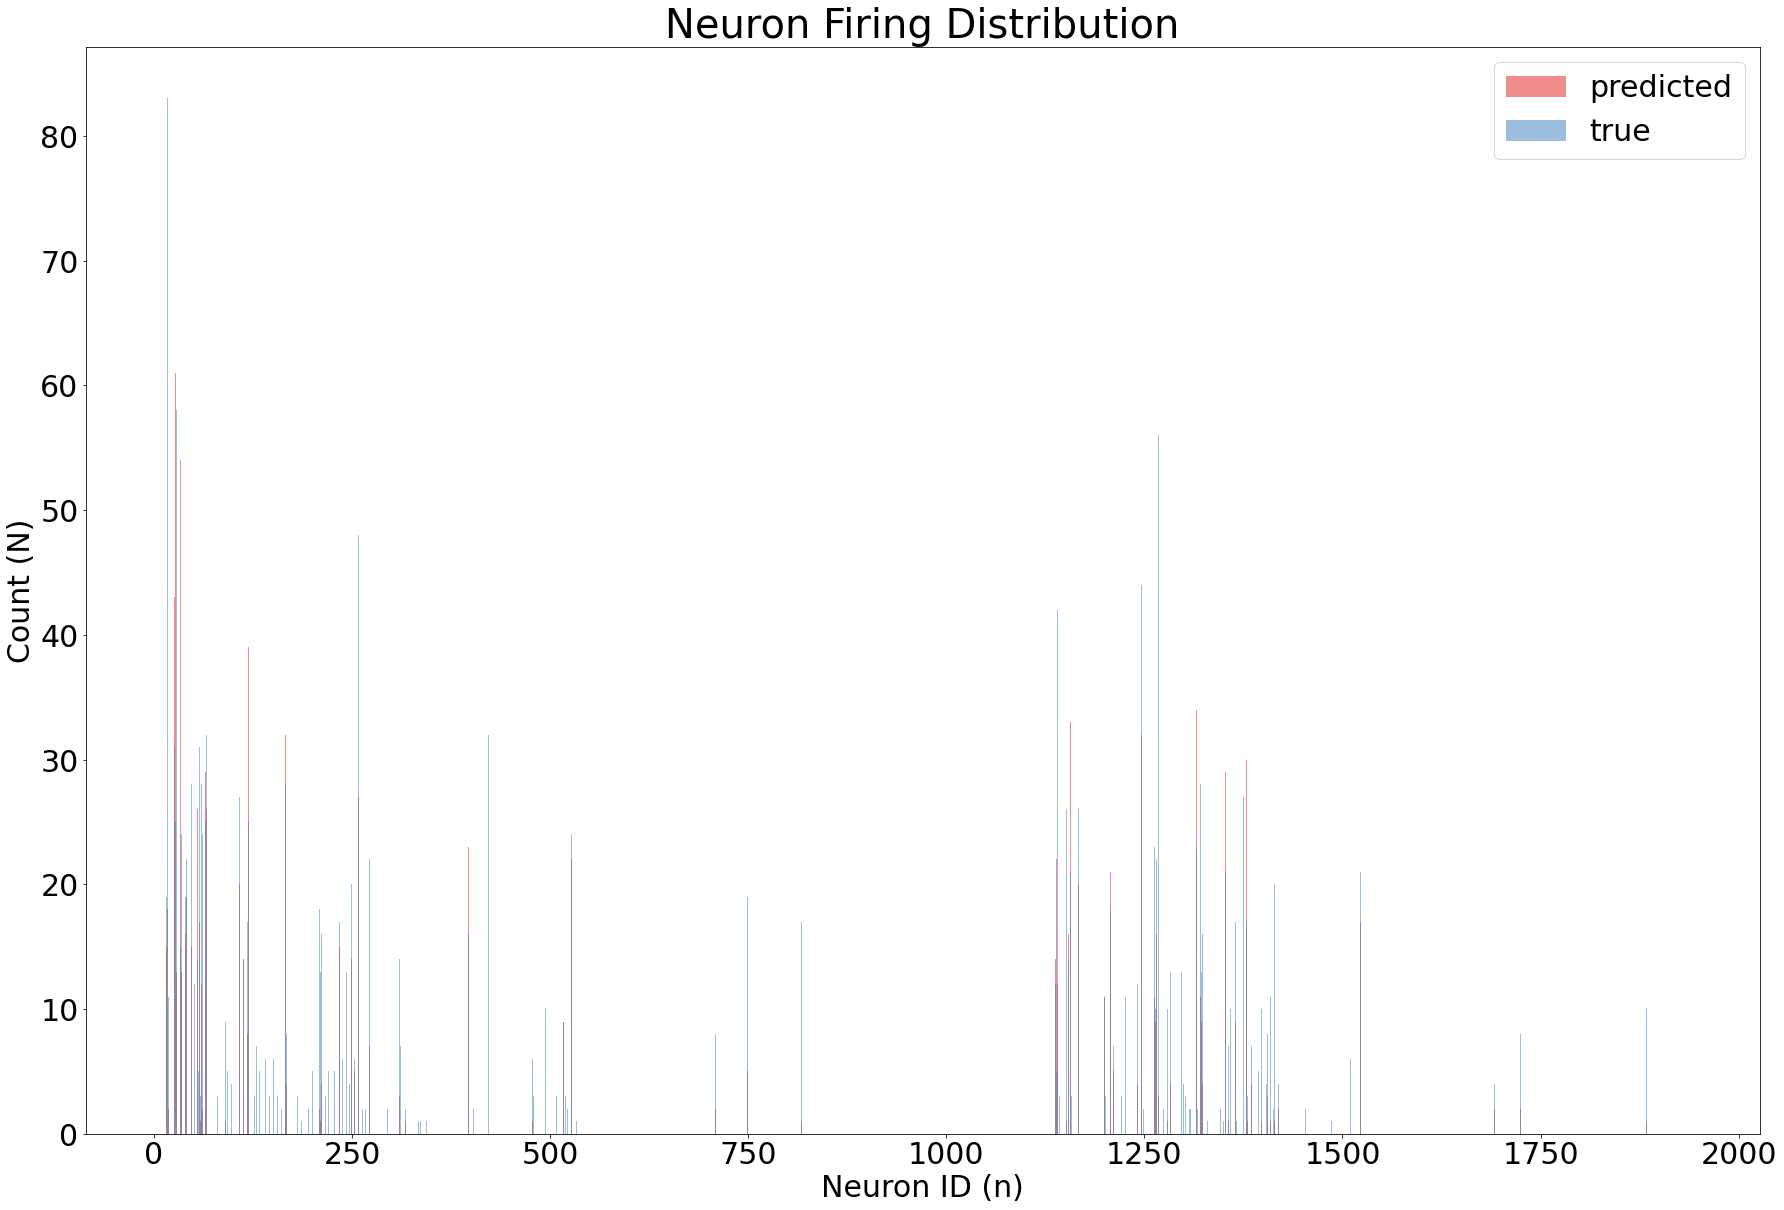

model: window:0.05_prev:0.2_smooth


In [30]:
"""

Evaluate results

"""

from visualize import *


len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_1)
pred_scores = compute_scores(df_1, df_pred_full)

print(f"pred: {pred_scores}")

n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=30)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['pred'] = pred_scores

print(f"model: {title}")


